In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import json
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Evaluation Environment Setup Complete!")

📊 Evaluation Environment Setup Complete!


In [2]:
# Import our recommendation system
import sys
sys.path.append('./algorithm')

from algorithm.collaborative_filtering import (
    CollaborativeFilter, 
    load_users_data, 
    get_recommendations
)

print("✅ Collaborative Filtering System Imported Successfully!")

✅ Collaborative Filtering System Imported Successfully!


## 1. Load Data and Setup

In [3]:
# Load movie dataset
df = pd.read_csv('dataset/movies.csv')
print(f"📽️ Loaded {len(df):,} movies from dataset")
print(f"Columns: {list(df.columns)}")

# Load user ratings data
users_data = load_users_data()
print(f"👥 Loaded ratings from {len(users_data)} users")

# Display basic statistics
print("\n📊 Dataset Overview:")
print(f"• Movies: {len(df):,}")
print(f"• Users: {len(users_data)}")
print(f"• Total ratings: {sum(len(ratings) for ratings in users_data.values()):,}")
print(f"• Avg ratings per user: {np.mean([len(ratings) for ratings in users_data.values()]):.1f}")
print(f"• Sparsity: {(1 - sum(len(ratings) for ratings in users_data.values()) / (len(users_data) * len(df))) * 100:.2f}%")

📽️ Loaded 9,985 movies from dataset
Columns: ['id', 'title', 'genre', 'original_language', 'overview', 'popularity', 'release_date', 'vote_average', 'vote_count']
👥 Loaded ratings from 38 users

📊 Dataset Overview:
• Movies: 9,985
• Users: 38
• Total ratings: 277
• Avg ratings per user: 7.3
• Sparsity: 99.93%


## 2. Data Preparation for Evaluation

In [4]:
def prepare_evaluation_data(users_data, test_size=0.2, min_ratings=3):
    """
    Split user ratings into train/test sets for evaluation.
    Only include users with minimum number of ratings.
    """
    train_data = {}
    test_data = {}
    
    valid_users = 0
    
    for user_id, ratings in users_data.items():
        if len(ratings) >= min_ratings:
            valid_users += 1
            
            # Convert to lists for splitting
            movies = list(ratings.keys())
            scores = list(ratings.values())
            
            # Split ratings
            train_movies, test_movies, train_scores, test_scores = train_test_split(
                movies, scores, test_size=test_size, random_state=42
            )
            
            # Create dictionaries
            train_data[user_id] = dict(zip(train_movies, train_scores))
            test_data[user_id] = dict(zip(test_movies, test_scores))
    
    print(f"📊 Evaluation Data Prepared:")
    print(f"• Valid users (≥{min_ratings} ratings): {valid_users}/{len(users_data)}")
    print(f"• Train ratings: {sum(len(r) for r in train_data.values()):,}")
    print(f"• Test ratings: {sum(len(r) for r in test_data.values()):,}")
    
    return train_data, test_data

# Prepare train/test split
train_data, test_data = prepare_evaluation_data(users_data)

📊 Evaluation Data Prepared:
• Valid users (≥3 ratings): 33/38
• Train ratings: 207
• Test ratings: 63


## 3. Rating Prediction Metrics (MAE, RMSE)

In [5]:
def evaluate_rating_prediction(train_data, test_data, df):
    """
    Evaluate rating prediction accuracy using MAE and RMSE.
    """
    all_predictions = []
    all_actuals = []
    user_results = []
    
    print("🔮 Evaluating Rating Prediction Accuracy...")
    
    for i, (user_id, test_ratings) in enumerate(test_data.items()):
        if i % 5 == 0:  # Progress indicator
            print(f"Progress: {i+1}/{len(test_data)} users")
        
        # Get training ratings for this user
        user_train_ratings = train_data.get(user_id, {})
        
        if not user_train_ratings:
            continue
        
        # Initialize recommender
        recommender = CollaborativeFilter(df)
        recommender.update_user_ratings(user_train_ratings)
        
        user_predictions = []
        user_actuals = []
        
        # Predict ratings for test movies
        for movie_id, actual_rating in test_ratings.items():
            predicted_rating = recommender.predict_rating(movie_id, train_data)
            
            user_predictions.append(predicted_rating)
            user_actuals.append(actual_rating)
            
            all_predictions.append(predicted_rating)
            all_actuals.append(actual_rating)
        
        # Calculate per-user metrics
        if user_predictions:
            user_mae = mean_absolute_error(user_actuals, user_predictions)
            user_rmse = np.sqrt(mean_squared_error(user_actuals, user_predictions))
            
            user_results.append({
                'user_id': user_id,
                'mae': user_mae,
                'rmse': user_rmse,
                'num_predictions': len(user_predictions)
            })
    
    # Calculate overall metrics
    overall_mae = mean_absolute_error(all_actuals, all_predictions)
    overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    
    print(f"\n📊 Rating Prediction Results:")
    print(f"• Overall MAE: {overall_mae:.3f}")
    print(f"• Overall RMSE: {overall_rmse:.3f}")
    print(f"• Total predictions: {len(all_predictions):,}")
    
    return {
        'mae': overall_mae,
        'rmse': overall_rmse,
        'predictions': all_predictions,
        'actuals': all_actuals,
        'user_results': user_results
    }

# Run rating prediction evaluation
rating_results = evaluate_rating_prediction(train_data, test_data, df)

🔮 Evaluating Rating Prediction Accuracy...
Progress: 1/33 users
Progress: 6/33 users
Progress: 11/33 users
Progress: 16/33 users
Progress: 21/33 users
Progress: 26/33 users
Progress: 31/33 users

📊 Rating Prediction Results:
• Overall MAE: 1.440
• Overall RMSE: 2.082
• Total predictions: 63


## 4. Ranking Metrics (Precision@K, Recall@K, F1@K)

In [6]:
def evaluate_ranking_metrics(train_data, test_data, df, k_values=[5, 10], relevance_threshold=7):
    """
    Evaluate ranking quality using Precision@K, Recall@K, F1@K, and NDCG@K.
    """
    results = {k: {'precision': [], 'recall': [], 'f1': [], 'ndcg': []} for k in k_values}
    
    print(f"🎯 Evaluating Ranking Metrics @K={k_values}...")
    
    for i, (user_id, test_ratings) in enumerate(test_data.items()):
        if i % 5 == 0:
            print(f"Progress: {i+1}/{len(test_data)} users")
            
        user_train_ratings = train_data.get(user_id, {})
        if not user_train_ratings:
            continue
            
        # Get recommendations
        try:
            recommendations = get_recommendations(df, user_train_ratings, max(k_values), train_data)
            
            if recommendations.empty:
                continue
                
            recommended_ids = recommendations['id'].astype(str).tolist()
            
            # Find relevant items in test set (high ratings)
            relevant_items = set(movie_id for movie_id, rating in test_ratings.items() 
                               if rating >= relevance_threshold)
            
            if not relevant_items:
                continue
            
            # Calculate metrics for each K
            for k in k_values:
                top_k_recs = set(recommended_ids[:k])
                
                # Precision@K
                precision = len(top_k_recs & relevant_items) / k if k > 0 else 0
                
                # Recall@K
                recall = len(top_k_recs & relevant_items) / len(relevant_items) if relevant_items else 0
                
                # F1@K
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                # NDCG@K (simplified)
                dcg = 0
                idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant_items), k)))
                
                for i, movie_id in enumerate(recommended_ids[:k]):
                    if movie_id in relevant_items:
                        dcg += 1 / np.log2(i + 2)
                
                ndcg = dcg / idcg if idcg > 0 else 0
                
                results[k]['precision'].append(precision)
                results[k]['recall'].append(recall)
                results[k]['f1'].append(f1)
                results[k]['ndcg'].append(ndcg)
                
        except Exception as e:
            continue
    
    # Calculate averages
    summary = {}
    for k in k_values:
        summary[k] = {
            'precision': np.mean(results[k]['precision']) if results[k]['precision'] else 0,
            'recall': np.mean(results[k]['recall']) if results[k]['recall'] else 0,
            'f1': np.mean(results[k]['f1']) if results[k]['f1'] else 0,
            'ndcg': np.mean(results[k]['ndcg']) if results[k]['ndcg'] else 0,
            'num_users': len(results[k]['precision'])
        }
        
        print(f"\n📊 Ranking Results @K={k}:")
        print(f"• Precision@{k}: {summary[k]['precision']:.3f}")
        print(f"• Recall@{k}: {summary[k]['recall']:.3f}")
        print(f"• F1@{k}: {summary[k]['f1']:.3f}")
        print(f"• NDCG@{k}: {summary[k]['ndcg']:.3f}")
        print(f"• Evaluated users: {summary[k]['num_users']}")
    
    return summary, results

# Run ranking evaluation
ranking_summary, ranking_details = evaluate_ranking_metrics(train_data, test_data, df)

🎯 Evaluating Ranking Metrics @K=[5, 10]...
Progress: 1/33 users
Progress: 6/33 users
Progress: 11/33 users
Progress: 16/33 users
Progress: 21/33 users
Progress: 26/33 users
Progress: 31/33 users

📊 Ranking Results @K=5:
• Precision@5: 0.156
• Recall@5: 0.412
• F1@5: 0.213
• NDCG@5: 0.303
• Evaluated users: 32

📊 Ranking Results @K=10:
• Precision@10: 0.103
• Recall@10: 0.480
• F1@10: 0.160
• NDCG@10: 0.335
• Evaluated users: 32


## 5. Coverage and Diversity Analysis

In [7]:
def evaluate_coverage_diversity(train_data, df, num_recommendations=10):
    """
    Evaluate catalog coverage and recommendation diversity.
    """
    all_recommendations = set()
    genre_distributions = []
    
    print("🎨 Evaluating Coverage and Diversity...")
    
    for i, (user_id, user_ratings) in enumerate(train_data.items()):
        if i % 5 == 0:
            print(f"Progress: {i+1}/{len(train_data)} users")
            
        try:
            recommendations = get_recommendations(df, user_ratings, num_recommendations, train_data)
            
            if not recommendations.empty:
                rec_ids = set(recommendations['id'].astype(str))
                all_recommendations.update(rec_ids)
                
                # Analyze genre diversity
                genres = []
                for _, movie in recommendations.iterrows():
                    movie_genres = str(movie['genre']).split(',')
                    genres.extend([g.strip() for g in movie_genres if g.strip()])
                
                # Calculate genre distribution
                unique_genres = len(set(genres))
                genre_distributions.append(unique_genres)
                
        except Exception as e:
            continue
    
    # Calculate metrics
    catalog_coverage = len(all_recommendations) / len(df)
    avg_genre_diversity = np.mean(genre_distributions) if genre_distributions else 0
    
    print(f"\n📊 Coverage & Diversity Results:")
    print(f"• Catalog Coverage: {catalog_coverage:.3f} ({len(all_recommendations):,}/{len(df):,} movies)")
    print(f"• Avg Genre Diversity: {avg_genre_diversity:.2f} unique genres per user")
    print(f"• Users analyzed: {len(genre_distributions)}")
    
    return {
        'catalog_coverage': catalog_coverage,
        'unique_movies_recommended': len(all_recommendations),
        'avg_genre_diversity': avg_genre_diversity,
        'genre_distributions': genre_distributions
    }

# Run coverage and diversity evaluation
coverage_results = evaluate_coverage_diversity(train_data, df)

🎨 Evaluating Coverage and Diversity...
Progress: 1/33 users
Progress: 6/33 users
Progress: 11/33 users
Progress: 16/33 users
Progress: 21/33 users
Progress: 26/33 users
Progress: 31/33 users

📊 Coverage & Diversity Results:
• Catalog Coverage: 0.013 (132/9,985 movies)
• Avg Genre Diversity: 7.79 unique genres per user
• Users analyzed: 33


## 6. User Similarity Analysis

In [8]:
def analyze_user_similarities(users_data, df, sample_size=10):
    """
    Analyze user similarity patterns in the recommendation system.
    """
    print("👥 Analyzing User Similarities...")
    
    # Sample users for analysis
    user_ids = list(users_data.keys())
    if len(user_ids) > sample_size:
        sample_users = np.random.choice(user_ids, sample_size, replace=False)
    else:
        sample_users = user_ids
    
    similarity_matrix = np.zeros((len(sample_users), len(sample_users)))
    
    for i, user1 in enumerate(sample_users):
        recommender = CollaborativeFilter(df)
        recommender.update_user_ratings(users_data[user1])
        
        # Build user-item matrix
        current_user_id = "current_user"
        all_users_with_current = users_data.copy()
        all_users_with_current[current_user_id] = users_data[user1]
        
        try:
            user_item_matrix = recommender._build_user_item_matrix(all_users_with_current)
            
            if not user_item_matrix.empty and current_user_id in user_item_matrix.index:
                # Calculate similarities with other sample users
                matrix_hash = hash(str(user_item_matrix.values.tobytes()))
                similarities = recommender._calculate_user_similarity(matrix_hash, current_user_id)
                
                for j, user2 in enumerate(sample_users):
                    if user2 in similarities.index:
                        similarity_matrix[i, j] = similarities[user2]
                        
        except Exception as e:
            continue
    
    # Calculate statistics
    avg_similarity = np.mean(similarity_matrix[similarity_matrix > 0])
    max_similarity = np.max(similarity_matrix)
    min_similarity = np.min(similarity_matrix[similarity_matrix > 0]) if np.any(similarity_matrix > 0) else 0
    
    print(f"\n📊 User Similarity Analysis:")
    print(f"• Average Similarity: {avg_similarity:.3f}")
    print(f"• Max Similarity: {max_similarity:.3f}")
    print(f"• Min Similarity: {min_similarity:.3f}")
    print(f"• Users analyzed: {len(sample_users)}")
    
    return {
        'similarity_matrix': similarity_matrix,
        'user_ids': sample_users,
        'avg_similarity': avg_similarity,
        'max_similarity': max_similarity,
        'min_similarity': min_similarity
    }

# Run user similarity analysis
similarity_results = analyze_user_similarities(users_data, df)

👥 Analyzing User Similarities...

📊 User Similarity Analysis:
• Average Similarity: nan
• Max Similarity: 0.000
• Min Similarity: 0.000
• Users analyzed: 10


## 7. Results Visualization

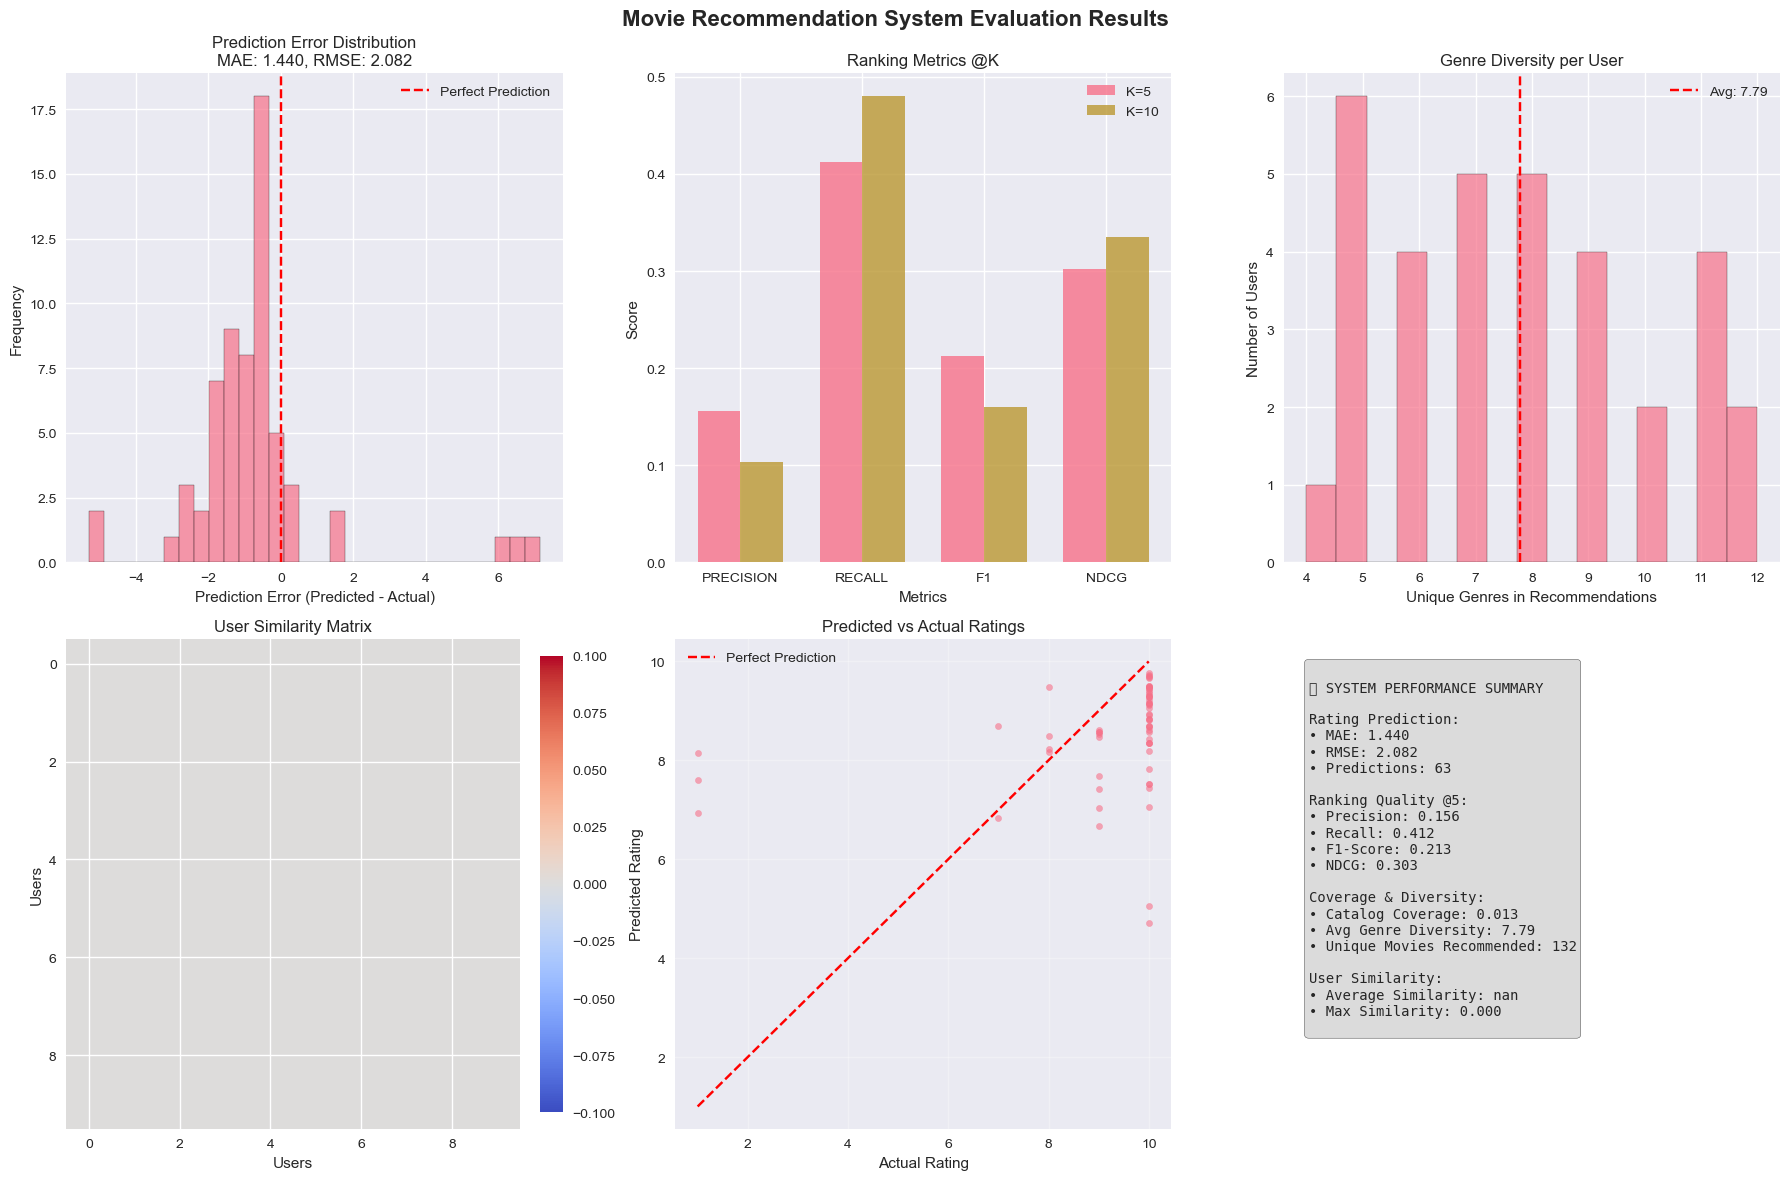


✅ Evaluation Complete! Check the visualizations above for detailed results.


In [9]:
# Create comprehensive results visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Movie Recommendation System Evaluation Results', fontsize=16, fontweight='bold')

# 1. Rating Prediction Error Distribution
errors = np.array(rating_results['predictions']) - np.array(rating_results['actuals'])
axes[0, 0].hist(errors, bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', label='Perfect Prediction')
axes[0, 0].set_title(f'Prediction Error Distribution\nMAE: {rating_results["mae"]:.3f}, RMSE: {rating_results["rmse"]:.3f}')
axes[0, 0].set_xlabel('Prediction Error (Predicted - Actual)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# 2. Ranking Metrics Comparison
k_values = list(ranking_summary.keys())
metrics = ['precision', 'recall', 'f1', 'ndcg']
x = np.arange(len(metrics))
width = 0.35

for i, k in enumerate(k_values):
    values = [ranking_summary[k][metric] for metric in metrics]
    axes[0, 1].bar(x + i*width, values, width, label=f'K={k}', alpha=0.8)

axes[0, 1].set_title('Ranking Metrics @K')
axes[0, 1].set_xlabel('Metrics')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x + width/2)
axes[0, 1].set_xticklabels([m.upper() for m in metrics])
axes[0, 1].legend()

# 3. Genre Diversity Distribution
if coverage_results['genre_distributions']:
    axes[0, 2].hist(coverage_results['genre_distributions'], bins=15, alpha=0.7, edgecolor='black')
    axes[0, 2].axvline(coverage_results['avg_genre_diversity'], color='red', linestyle='--', 
                      label=f'Avg: {coverage_results["avg_genre_diversity"]:.2f}')
    axes[0, 2].set_title('Genre Diversity per User')
    axes[0, 2].set_xlabel('Unique Genres in Recommendations')
    axes[0, 2].set_ylabel('Number of Users')
    axes[0, 2].legend()
else:
    axes[0, 2].text(0.5, 0.5, 'No Genre Data Available', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('Genre Diversity per User')

# 4. User Similarity Heatmap
if similarity_results['similarity_matrix'].size > 0:
    im = axes[1, 0].imshow(similarity_results['similarity_matrix'], cmap='coolwarm', aspect='auto')
    axes[1, 0].set_title('User Similarity Matrix')
    axes[1, 0].set_xlabel('Users')
    axes[1, 0].set_ylabel('Users')
    plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
else:
    axes[1, 0].text(0.5, 0.5, 'Similarity Matrix\nNot Available', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('User Similarity Matrix')

# 5. Prediction vs Actual Scatter Plot
sample_size = min(1000, len(rating_results['predictions']))
indices = np.random.choice(len(rating_results['predictions']), sample_size, replace=False)
sample_pred = [rating_results['predictions'][i] for i in indices]
sample_actual = [rating_results['actuals'][i] for i in indices]

axes[1, 1].scatter(sample_actual, sample_pred, alpha=0.6, s=20)
axes[1, 1].plot([1, 10], [1, 10], 'r--', label='Perfect Prediction')
axes[1, 1].set_title('Predicted vs Actual Ratings')
axes[1, 1].set_xlabel('Actual Rating')
axes[1, 1].set_ylabel('Predicted Rating')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. System Performance Summary
axes[1, 2].axis('off')
summary_text = f"""
📊 SYSTEM PERFORMANCE SUMMARY

Rating Prediction:
• MAE: {rating_results['mae']:.3f}
• RMSE: {rating_results['rmse']:.3f}
• Predictions: {len(rating_results['predictions']):,}

Ranking Quality @5:
• Precision: {ranking_summary.get(5, {}).get('precision', 0):.3f}
• Recall: {ranking_summary.get(5, {}).get('recall', 0):.3f}
• F1-Score: {ranking_summary.get(5, {}).get('f1', 0):.3f}
• NDCG: {ranking_summary.get(5, {}).get('ndcg', 0):.3f}

Coverage & Diversity:
• Catalog Coverage: {coverage_results['catalog_coverage']:.3f}
• Avg Genre Diversity: {coverage_results['avg_genre_diversity']:.2f}
• Unique Movies Recommended: {coverage_results['unique_movies_recommended']:,}

User Similarity:
• Average Similarity: {similarity_results['avg_similarity']:.3f}
• Max Similarity: {similarity_results['max_similarity']:.3f}
"""

axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes, 
               fontsize=10, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n✅ Evaluation Complete! Check the visualizations above for detailed results.")

## 8. Detailed Results Export

In [10]:
# Create comprehensive results summary
final_results = {
    'evaluation_summary': {
        'dataset_info': {
            'total_movies': len(df),
            'total_users': len(users_data),
            'total_ratings': sum(len(ratings) for ratings in users_data.values()),
            'sparsity': (1 - sum(len(ratings) for ratings in users_data.values()) / (len(users_data) * len(df))) * 100
        },
        'rating_prediction': {
            'mae': rating_results['mae'],
            'rmse': rating_results['rmse'],
            'total_predictions': len(rating_results['predictions'])
        },
        'ranking_metrics': ranking_summary,
        'coverage_diversity': {
            'catalog_coverage': coverage_results['catalog_coverage'],
            'unique_movies_recommended': coverage_results['unique_movies_recommended'],
            'avg_genre_diversity': coverage_results['avg_genre_diversity']
        },
        'user_similarity': {
            'avg_similarity': similarity_results['avg_similarity'],
            'max_similarity': similarity_results['max_similarity'],
            'min_similarity': similarity_results['min_similarity']
        }
    }
}

# Save results to JSON file
with open('evaluation_results.json', 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print("💾 Results saved to 'evaluation_results.json'")

# Display final summary
print("\n🎯 FINAL EVALUATION SUMMARY")
print("=" * 50)
print(f"Dataset: {len(df):,} movies, {len(users_data)} users, {sum(len(r) for r in users_data.values()):,} ratings")
print(f"Rating Prediction - MAE: {rating_results['mae']:.3f}, RMSE: {rating_results['rmse']:.3f}")
print(f"Ranking @5 - Precision: {ranking_summary.get(5, {}).get('precision', 0):.3f}, Recall: {ranking_summary.get(5, {}).get('recall', 0):.3f}")
print(f"Coverage: {coverage_results['catalog_coverage']:.3f} ({coverage_results['unique_movies_recommended']:,} movies)")
print(f"Diversity: {coverage_results['avg_genre_diversity']:.2f} genres per user")
print(f"User Similarity: Avg {similarity_results['avg_similarity']:.3f}")
print("=" * 50)

💾 Results saved to 'evaluation_results.json'

🎯 FINAL EVALUATION SUMMARY
Dataset: 9,985 movies, 38 users, 277 ratings
Rating Prediction - MAE: 1.440, RMSE: 2.082
Ranking @5 - Precision: 0.156, Recall: 0.412
Coverage: 0.013 (132 movies)
Diversity: 7.79 genres per user
User Similarity: Avg nan
